# How to use GEORCE

In [52]:
## Import modules
# jax
import jax.numpy as jnp
from jax import vmap, Array

# matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#abc
from abc import ABC

# georce
from georce import GEORCE_R, GEORCE_F

# manifold
from geometry.manifolds.riemannian import nSphere
from geometry.manifolds.finsler import RiemannianNavigation

In [28]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

## Hyper-Parameters

In [29]:
T = 100 #number of grid points
tol = 1e-4 #tolerance
max_iter = 1000 #maximum number of iterations
rho = 0.5 #backtracking parameter

In [30]:
#Initial guess of the curve
def init_curve(z0,zT,T):
    curve = (zT-z0)*jnp.linspace(0.0,1.0,T,endpoint=False,dtype=z0.dtype)[1:].reshape(-1,1)+z0
    
    return curve

## Computing Geodesics on Riemmanian manifolds for $\mathbb{S}^{2}$

In [31]:
#Setting up the manifold
M = nSphere(dim=2)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = M.f(z0)
s2_xT = M.f(zT)

In [32]:
#defining GEORCE
Geodesic = GEORCE_R(G=M.G,
                    init_fun=init_curve,
                    T=T,
                    tol=tol,
                    max_iter=max_iter,
                    line_search_params = {'rho': rho},
                    )

In [33]:
#Computing estimate
zt_geodesic = Geodesic(z0, zT)

In [34]:
#mapping the geodesic from chart to manifold
xt_geodesic = vmap(M.f)(zt_geodesic)

In [35]:
#initial curve
zt_init = jnp.vstack((z0,init_curve(z0,zT,T),zT))
xt_init = vmap(M.f)(zt_init)

### Plotting 

In [36]:
class EllipsoidPlot(ABC):
    def __init__(self, params=jnp.linspace(0.5,1.0,3)[::-1]):
        
        self.params = params

    def grid(self, n_points:int=100):
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

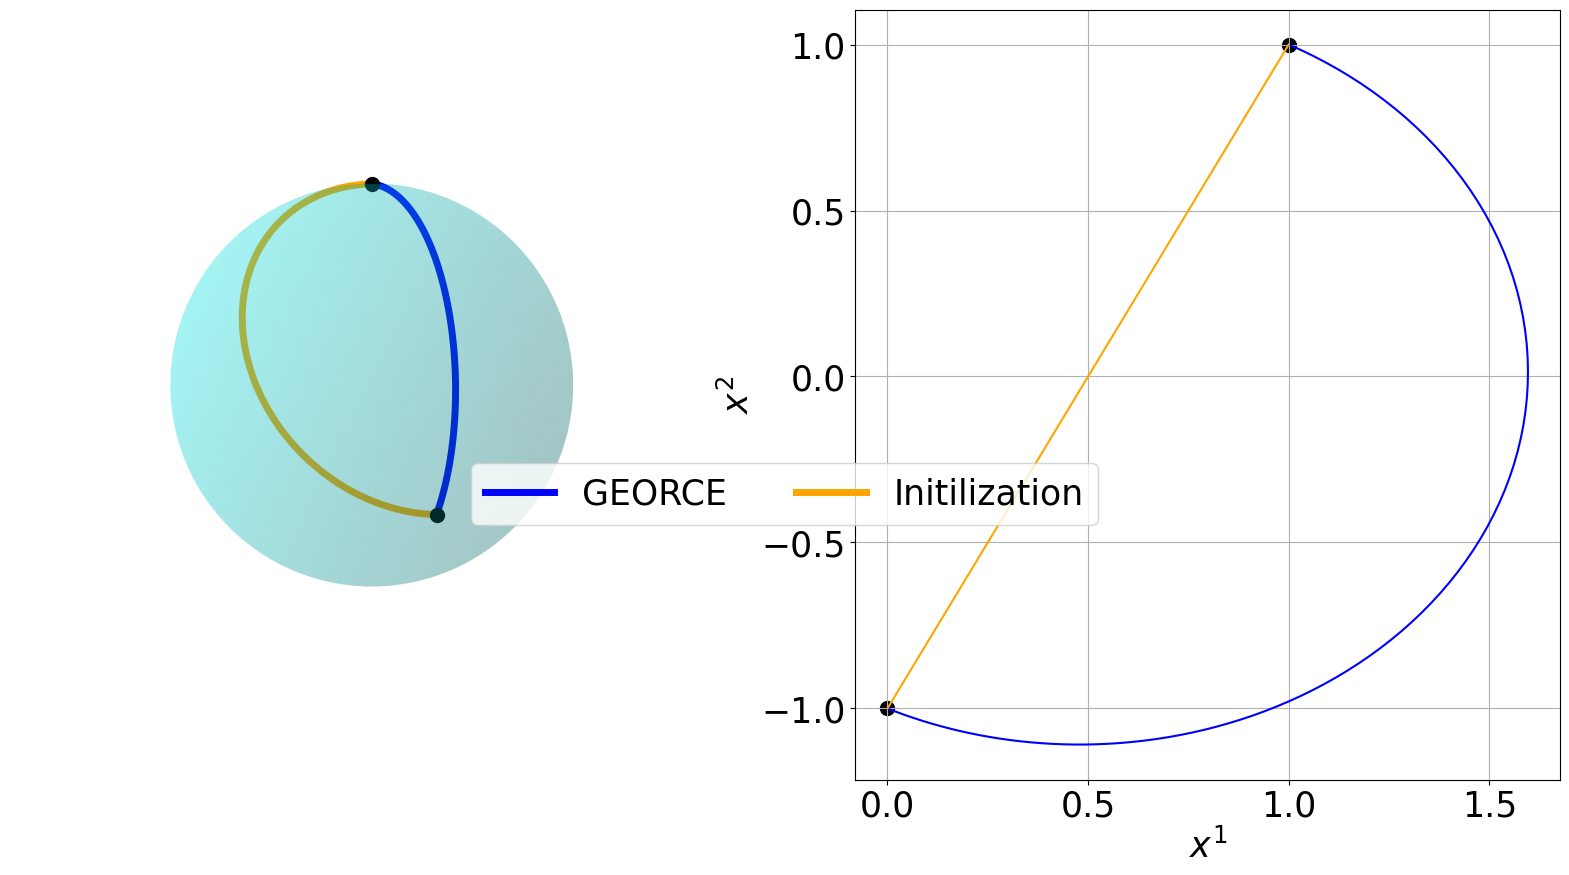

In [40]:
fig = plt.figure(figsize=(20,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(xt_geodesic[:,0], xt_geodesic[:,1], xt_geodesic[:,2], alpha=1.0, label=f"GEORCE", linewidth=5.0,
       color='blue')
ax.plot(xt_init[:,0], xt_init[:,1], xt_init[:,2], alpha=1.0, label=f"Initilization", linewidth=5.0,
       color='orange')
    
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.3,0.40), ncol=2)

ax = fig.add_subplot(122)
ax.plot(zt_geodesic[:,0], zt_geodesic[:,1], color='blue')
ax.plot(zt_init[:,0], zt_init[:,1], color='orange')
ax.scatter(z0[0], z0[1], color='black', alpha=1.0, s=100)
ax.scatter(zT[0], zT[1], color='black', alpha=1.0, s=100)

ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

## Computing Geodesics on Finsler manifolds for $\mathbb{S}^{2}$ with force fields

### Defining Force Field

In [41]:
def force_fun(z, M):
    
    val = jnp.cos(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return jnp.sin(z)*val/val2
    
v0 = 1.5

### Defining Finsler manifold and Compute Geodesic

In [45]:
RM = nSphere(dim=2)

z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = RM.f(z0)
s2_xT = RM.f(zT)

M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [47]:
#defining GEORCE
Geodesic = GEORCE_F(F=M.F,
                    init_fun=init_curve,
                    T=T,
                    tol=tol,
                    max_iter=max_iter,
                    line_search_params = {'rho': rho},
                    )

In [48]:
#Computing estimate
zt_geodesic = Geodesic(z0, zT)

In [49]:
#mapping the geodesic from chart to manifold
xt_geodesic = vmap(M.f)(zt_geodesic)

In [50]:
#initial curve
zt_init = jnp.vstack((z0,init_curve(z0,zT,T),zT))
xt_init = vmap(M.f)(zt_init)

### Plotting

In [55]:
class EllipsoidPlot(ABC):
    def __init__(self, 
                 params=jnp.linspace(0.5,1.0,3)[::-1],
                ):
        
        self.M = nSphere(dim=2)
        self.force_fun = lambda z: force_fun(z, self.M)
        self.params = params

    def heat_map(self, X, Y, Z)->Array:
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        heat_map = vmap(lambda z1: vmap(lambda z: jnp.linalg.norm(self.force_fun(z)))(z1))(z)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        X,Y,Z = self.grid(n_points)
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        force = vmap(lambda z1: vmap(lambda z: jnp.dot(self.M.Jf(z), self.force_fun(z)))(z1))(z)
        
        return X,Y,Z,force
        
    def grid(self, n_points:int=100)->Array:
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

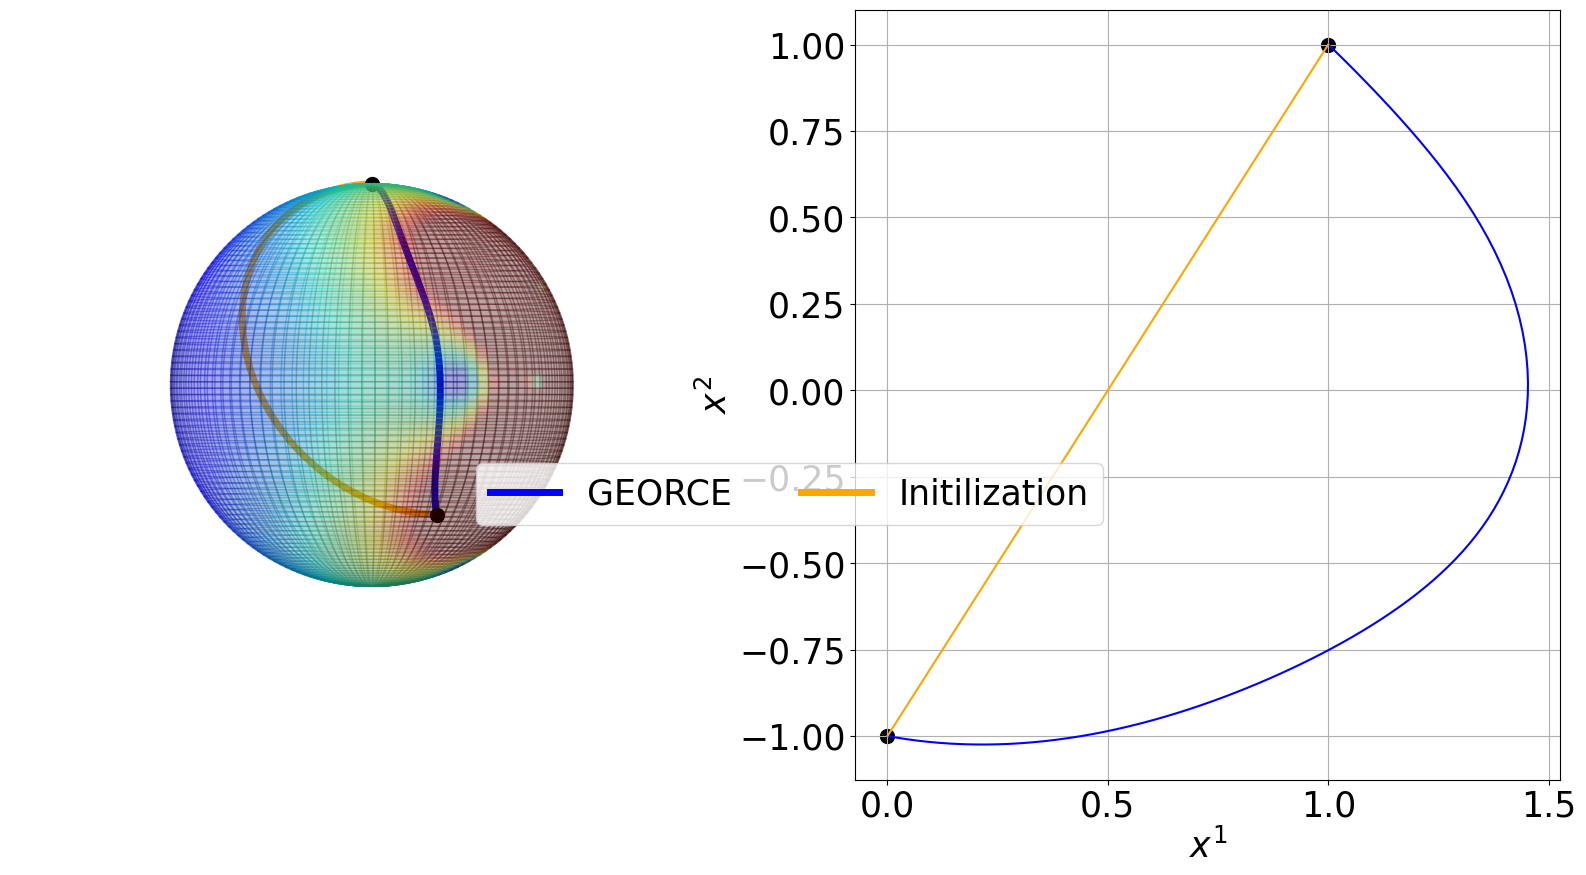

In [60]:
fig = plt.figure(figsize=(20,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.plot(xt_geodesic[:,0], xt_geodesic[:,1], xt_geodesic[:,2], alpha=1.0, label=f"GEORCE", linewidth=5.0,
       color='blue')
ax.plot(xt_init[:,0], xt_init[:,1], xt_init[:,2], alpha=1.0, label=f"Initilization", linewidth=5.0,
       color='orange')
    
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.3,0.40), ncol=2)

ax = fig.add_subplot(122)
ax.plot(zt_geodesic[:,0], zt_geodesic[:,1], color='blue')
ax.plot(zt_init[:,0], zt_init[:,1], color='orange')
ax.scatter(z0[0], z0[1], color='black', alpha=1.0, s=100)
ax.scatter(zT[0], zT[1], color='black', alpha=1.0, s=100)

ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)